<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model_D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PRUEBAS CON DATASET D1

7 características: mediana, desviación típica, max, min, AuC, nºSCR, potencia

## 1. Inicialización de Keras y TensorFlow

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import ceil

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [ ]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D1.csv'
column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Total Area', 'nº SCR', 'Power', 'State']

raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = raw_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

Formato del dataset: (4471, 8)
Recuento de instancias por clase:
State
1    2739
0    1732
Name: count, dtype: int64


In [ ]:
raw_dataset.head()  # muestra las primeras 5 filas por defecto

,Median,Standard Dev,Max Value,Min Value,Total Area,nº SCR,Power,State
0,0.395627,0.045027,0.441376,0.017854,46.475522,20,18.395499,0
1,0.372022,0.015806,0.383590,0.235340,44.127914,23,16.484996,0
2,0.352193,0.010449,0.410534,0.281604,41.974644,21,14.918425,0
3,0.355090,0.003470,0.365839,0.350073,42.350398,21,15.197816,0
4,0.365187,0.045893,0.460631,0.034430,42.631261,21,15.656409,0


In [ ]:
raw_dataset.tail() # muestra las últimas 5 filas por defecto

,Median,Standard Dev,Max Value,Min Value,Total Area,nº SCR,Power,State
4466,1.842418,1.255699,3.101320,-0.139569,179.464628,18,460.151160,1
4467,0.030843,0.943659,2.952972,-0.080004,59.033454,18,136.302654,1
4468,2.982710,1.000780,3.030685,-0.083926,299.016366,18,871.522788,1
4469,2.944818,0.043836,3.113192,2.647263,350.207754,18,1039.546650,1
4470,2.866678,0.263711,2.905342,0.000000,339.147681,18,975.013987,1


## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [ ]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = raw_dataset.drop('State', axis=1)
labels = raw_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)

In [ ]:
# Extracción de subconjuntos: bloque de código original original
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
#del train_dataset['Number of SCR']
#del test_dataset['Number of SCR']

In [ ]:
#del train_dataset['Power']
#del test_dataset['Power']
#del train_dataset['Total Area']
#del test_dataset['Total Area']
#a= train_dataset.pop('Power')
#b=train_dataset.pop('Total Area')
#c=test_dataset.pop('Power')
#d=test_dataset.pop('Total Area')
train_size = train_dataset.shape
test_size = test_dataset.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

Formato del dataset de training: (3576, 7)
Formato del dataset de test: (895, 7)


,count,mean,std,min,25%,50%,75%,max
Median,3576.0,1.346832,2.502091,2.351932e-22,0.234657,0.419105,1.012543,17.070575
Standard Dev,3576.0,0.141616,0.360931,7.505391e-04,0.006561,0.030638,0.116349,6.529530
Max Value,3576.0,1.603202,2.760735,6.211061e-03,0.297699,0.499387,1.370866,20.546044
Min Value,3576.0,1.053159,2.269433,-2.450087e-01,0.065922,0.281587,0.640681,16.056648
Total Area,3576.0,159.979153,296.008940,3.457700e-02,28.018526,50.021007,121.226126,2020.010062
nº SCR,3576.0,18.337808,4.634680,0.000000e+00,16.000000,19.000000,21.000000,30.000000
Power,3576.0,976.884222,3410.113652,1.827353e-04,7.189778,22.157031,143.323471,34729.312397


### 3.2. Normalización y estandarización de todos los datos

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

Formato del dataset de training: (3576, 7)
Formato del dataset de test: (895, 7)


,count,mean,std,min,25%,50%,75%,max
Median,3576.0,1.122642e-16,1.0,-0.538282,-0.444498,-0.370781,-0.133604,6.284241
Standard Dev,3576.0,-6.954417e-18,1.0,-0.390283,-0.374186,-0.307476,-0.070005,17.698429
Max Value,3576.0,4.967441e-18,1.0,-0.578466,-0.472882,-0.399826,-0.084157,6.861522
Min Value,3576.0,-5.960929e-17,1.0,-0.572023,-0.435015,-0.339985,-0.181754,6.611119
Total Area,3576.0,5.265487e-17,1.0,-0.540337,-0.445799,-0.371469,-0.130918,6.283698
nº SCR,3576.0,-1.351144e-16,1.0,-3.956650,-0.504416,0.142878,0.574407,2.516289
Power,3576.0,-1.390883e-17,1.0,-0.286467,-0.284358,-0.279969,-0.244438,9.897743


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [ ]:
from keras import Sequential, layers, activations

In [ ]:
def build_model_A(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_A(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 7, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 189)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 22)             │         4,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,284 (16.73 KB)

 Trainable params: 4,284 (16.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_model_B(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_B(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 7, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 7, 22)          │         1,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 154)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 22)             │         3,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,318 (20.77 KB)

 Trainable params: 5,318 (20.77 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [ ]:
from keras import callbacks
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # o 'val_accuracy'
    patience=100,              # número de épocas que espera sin mejora
    restore_best_weights=True  # para recuperar los mejores pesos
)

In [ ]:
EPOCHS = 1000
#BATCH_SIZE = train_size[0]
BATCH_SIZE = ceil(train_size[0]*0.15)
history = model.fit(normed_train_data, train_labels, batch_size=BATCH_SIZE,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
995,0.683217,0.760728,0.565854,0.684645,0.896866,0.662011,0.756944,0.623697,0.678967,0.844037,995
996,0.688112,0.760728,0.564613,0.693238,0.882051,0.641061,0.756944,0.631814,0.650927,0.885321,996
997,0.684965,0.760728,0.567614,0.683893,0.904843,0.659218,0.756944,0.628514,0.695918,0.782110,997
998,0.690210,0.760728,0.567648,0.712469,0.830199,0.639665,0.756944,0.626494,0.651877,0.876147,998
999,0.685664,0.760728,0.568299,0.683062,0.909972,0.656425,0.756944,0.630776,0.675926,0.837156,999


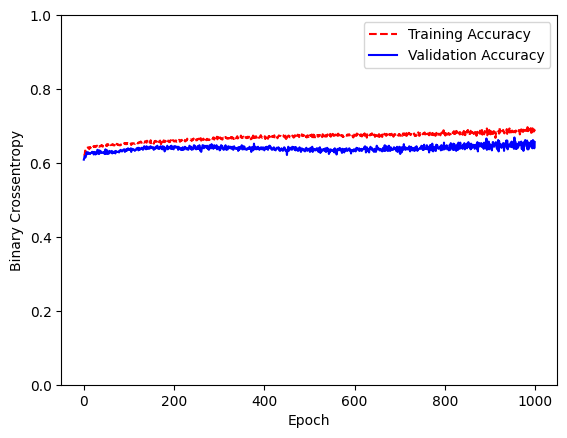

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [ ]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - binary_accuracy: 0.6570 - f1_score: 0.7601 - loss: 0.6438 - precision: 0.6764 - recall: 0.8431
Test accuracy: 65.70%
Test loss: 0.644


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


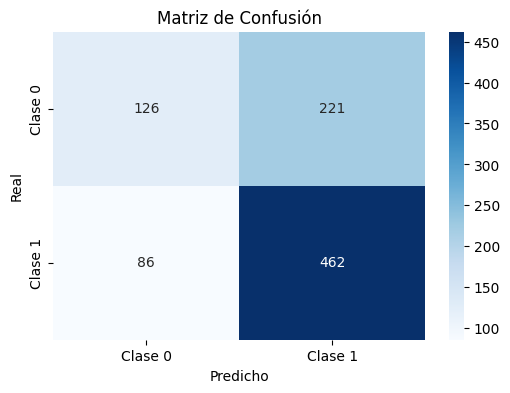

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.59      0.36      0.45       347
     Clase 1       0.68      0.84      0.75       548

    accuracy                           0.66       895
   macro avg       0.64      0.60      0.60       895
weighted avg       0.64      0.66      0.63       895



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))
